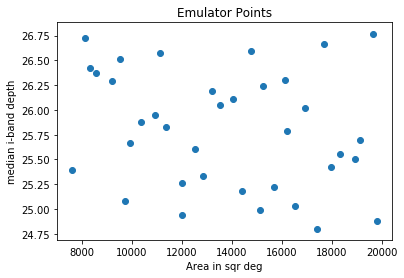

In [20]:
import sys
import numpy as np
from numpy import linalg as LA
from pyDOE import *
import george
from george.kernels import ExpSquaredKernel
import matplotlib.pyplot as plt

#Create design in area and depth
design = lhs(6, samples=36)
idepth_lims=[24.8,26.8] # this is corresponds to the definiotion of idepth=ilim+1; idepth corresponds to median i-band depth, see https://github.com/LSSTDESC/ObsStrat/tree/static/static
area_lims=[7500,20000]
shear_m_lims=[0.002,0.02]
# Rachel: 0.01 is too optimistic 0.02 instead, 0.05 is too opti, choose 0.08
sigma_z_lims=[0.05,0.01] #Gaussian photo-z: sig_z is the 68% credible region around the Gaussian tomographic mean. 
sig_delta_z_lims=[0.001,0.005]  # Gaussian prior on delta_z
sig_sigma_z_lims=[0.003,0.006]  # Gaussian prior on sigma_z 

design[:,0]=area_lims[0]+(area_lims[1]-area_lims[0])*design[:,0]
design[:,1]=idepth_lims[0]+(idepth_lims[1]-idepth_lims[0])*design[:,1]
design[:,2]=shear_m_lims[0]+(shear_m_lims[1]-shear_m_lims[0])*design[:,2]
design[:,3]=sigma_z_lims[0]+(sigma_z_lims[1]-sigma_z_lims[0])*design[:,3]
design[:,4]=sig_delta_z_lims[0]+(sig_delta_z_lims[1]-sig_delta_z_lims[0])*design[:,4]
design[:,5]=sig_sigma_z_lims[0]+(sig_sigma_z_lims[1]-sig_sigma_z_lims[0])*design[:,5]

plt.scatter(design[:,0],design[:,1])
plt.title("Emulator Points")
plt.xlabel("Area in sqr deg")
plt.ylabel("median i-band depth")
plt.show()

In [31]:
# Compute redshift distribution parameters based on fitting functions derived here 
# https://github.com/LSSTDESC/ObsStrat/tree/static/static

# idepth=design[:,1]
# idepth[0]=24
# 
# areavalues=design[:,0]
# LSSneff=37.8*10**(0.359*(ilim - 25))
# LSSz0 = 0.00627*(ilim-25)**2+0.0188*(ilim-25)+0.272
# LSSalpha = 0.0125*(ilim-25)**2-0.025*(ilim-25)+0.909
# WLneff = 4.33*(idepth-25)**2+7.03*(idepth-25)+10.49
# WLz0 = -0.0125*(idepth-25)+0.193 
# WLalpha = -0.069*(idepth-25)+0.876


# new fitting formula from Xiao
area=design[:,0]
idepth=design[:,1]
shear_m=design[:,2]
design[:,3]=(design[:,3]-sigma_z_lims[0])/(sigma_z_lims[1]-sigma_z_lims[0])
sigma_z=design[:,3]
sig_delta_z=design[:,4]
sig_sigma_z= design[:,5]

#check with Xiao on how he exactly derived this
WLneff = 10.47*10**(0.3167*(idepth - 25.))
WLz0 = -0.0125*(idepth-25)+0.193 
WLalpha = -0.069*(idepth-25)+0.876

ilim=idepth-1
LSSneff=37.8*10**(0.359*(ilim - 25))
LSSz0 = 0.00627*(ilim-25)**2+0.0188*(ilim-25)+0.272
LSSalpha = 0.0125*(ilim-25)**2-0.025*(ilim-25)+0.909


In [35]:
# Tabulate design and derived parameters
from tabulate import tabulate
sigma_z=0.01+(0.1-0.01)*design[:,3]
table=zip(area,idepth,WLneff,WLz0,WLalpha,LSSneff,LSSz0,LSSalpha,shear_m,sigma_z,sig_delta_z,sig_sigma_z)
header=["area","idepth","WLneff","WLz0","WLalpha","LSSneff","LSSz0","LSSalpha","shear_m","sigma_z","sig_delta_z","sig_sigma_z"]
print tabulate(table, header)

    area    idepth    WLneff      WLz0    WLalpha    LSSneff     LSSz0    LSSalpha     shear_m    sigma_z    sig_delta_z    sig_sigma_z
--------  --------  --------  --------  ---------  ---------  --------  ----------  ----------  ---------  -------------  -------------
 7623.22   25.3975  13.991    0.188031   0.848569    22.9726  0.26295     0.928598  0.00891915  0.0849973     0.0032537      0.00331909
14786.3    26.5907  33.3975   0.173117   0.766243    61.5948  0.285292    0.898594  0.0104498   0.0986032     0.00135316     0.00529541
 9931.47   25.6702  17.069    0.184622   0.829754    28.7809  0.266482    0.918604  0.0145972   0.0875521     0.00168787     0.00478151
 8585.43   26.3726  28.4875   0.175842   0.781289    51.4354  0.279876    0.90142   0.0191916   0.0968222     0.00215043     0.00437497
17681.8    26.6691  35.3643   0.172136   0.760829    65.7226  0.287387    0.897868  0.00450246  0.0225239     0.00406031     0.00443062
15126.9    24.9882  10.3802   0.193148   0.87681

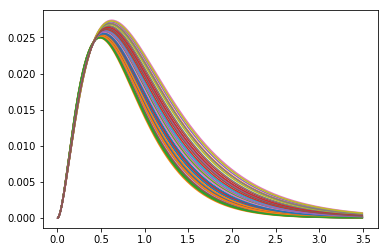

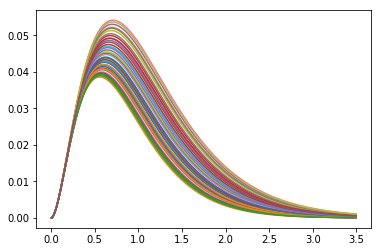

In [30]:
# Create redshift distribution files
zbin=300
zrange=[i for i in np.linspace(0.000001,3.5,zbin+1)]
zmin=zrange[0:300]
zmax=zrange[1:301]
zmid=[0.0]*zbin
for i in range(zbin): 
    zmid[i]=(zmin[i]+zmax[i])/2
nzWL=[0.0]*zbin
nzLSS=[0.0]*zbin

plt.figure(0)
plt.figure(1)
for i in range(len(design[:,1])):
    f = open('zdistris/wl_redshift_model%d_WLz0%e_WLalpha%e.txt'%(i,WLz0[i],WLalpha[i]),'w')
    g = open('zdistris/LSS_redshift_model%d_LSSz0%e_LSSalpha%e.txt'%(i,LSSz0[i],LSSalpha[i]),'w')
    for j in range(zbin):
        nzWL[j]=zmid[j]**2.0*np.exp(-((zmid[j]/WLz0[i])**WLalpha[i]))
        nzLSS[j]=zmid[j]**2.0*np.exp(-((zmid[j]/LSSz0[i])**LSSalpha[i]))
        f.write('%e %e %e %e\n'%(zmin[j],zmid[j],zmax[j],nzWL[j]))
        g.write('%e %e %e %e\n'%(zmin[j],zmid[j],zmax[j],nzLSS[j]))
    plt.figure(0)
    plt.plot(zmid,nzWL)
    plt.figure(1)
    plt.plot(zmid,nzLSS)
    f.close()
    g.close()
plt.show()
